# fashion mnist

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals
import matplotlib.pyplot as plt

import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras


In [3]:
print(tf.__version__)


2.0.0


In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape[0]

60000

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

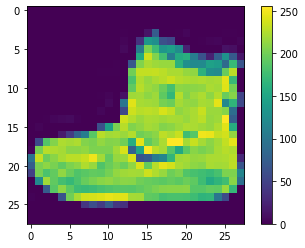

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

# 1. fashion model 학습하기(baseline_model)

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.5017 - accuracy: 0.8239
Epoch 2/5
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3805 - accuracy: 0.8615
Epoch 3/5
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3400 - accuracy: 0.8761
Epoch 4/5
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3166 - accuracy: 0.8846
Epoch 5/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.2978 - accuracy: 0.8897


##### accuracy : baseline

In [13]:
test_loss, baseline_model_accuracy = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', baseline_model_accuracy)

10000/1 - 1s - loss: 0.2683 - accuracy: 0.8737

테스트 정확도: 0.8737


In [14]:
predictions = model.predict(test_images)

In [15]:
predictions[0]

array([7.8319878e-05, 1.3736968e-08, 5.3020108e-07, 2.7694304e-07,
       9.8753399e-06, 2.4271445e-02, 7.0330630e-06, 5.4183874e-02,
       1.5012491e-04, 9.2129850e-01], dtype=float32)

In [16]:
np.argmax(predictions[0])

9

In [17]:
test_labels[0]

9

In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


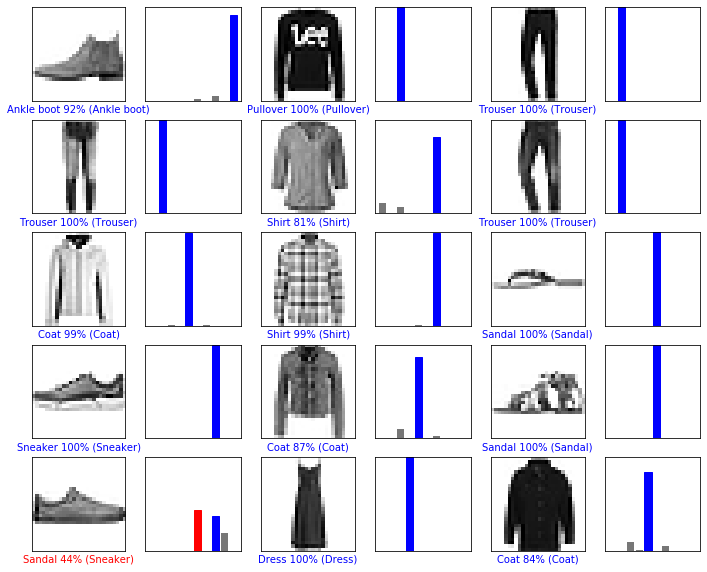

In [19]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

In [20]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28)


In [21]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmpe_hk9jhp.h5


# 2. baseline model with only pruning

In [22]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 4 epochs.
batch_size = 128
epochs = 6
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_flatten  (None, 784)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 128)               200834    
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 10)                2572      
Total params: 203,407
Trainable params: 101,770
Non-trainable params: 101,637
_________________________________________________________________


In [23]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Train on 54000 samples, validate on 6000 samples
Epoch 1/6
54000/54000 [==============================] - 4s 73us/sample - loss: 1.5915 - accuracy: 0.8865 - val_loss: 1.5936 - val_accuracy: 0.8810
Epoch 2/6
54000/54000 [==============================] - 3s 56us/sample - loss: 1.5941 - accuracy: 0.8840 - val_loss: 1.5975 - val_accuracy: 0.8798
Epoch 3/6
54000/54000 [==============================] - 3s 55us/sample - loss: 1.5999 - accuracy: 0.8794 - val_loss: 1.6010 - val_accuracy: 0.8785
Epoch 4/6
54000/54000 [==============================] - 3s 52us/sample - loss: 1.6074 - accuracy: 0.8725 - val_loss: 1.6027 - val_accuracy: 0.8757
Epoch 5/6
54000/54000 [==============================] - 3s 53us/sample - loss: 1.6045 - accuracy: 0.8752 - val_loss: 1.6054 - val_accuracy: 0.8717
Epoch 6/6
54000/54000 [==============================] - 3s 53us/sample - loss: 1.5976 - accuracy: 0.8776 - val_loss: 1.6010 - val_accuracy: 0.8697


##### accuracy : baseline,  pruned model

In [24]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.8737
Pruned test accuracy: 0.8629


In [25]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp2frnpiex.h5


# 3-1. baseline model with only quantizing

In [26]:
quantize_model = tfmot.quantization.keras.quantize_model

In [27]:
q_aware_model = quantize_model(model)

In [28]:
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
q_aware_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_flatten (QuantizeWrapp (None, 784)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 128)               100485    
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                1295      
Total params: 101,781
Trainable params: 101,770
Non-trainable params: 11
_________________________________________________________________


In [30]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=5, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 1s 584us/sample - loss: 1.6329 - accuracy: 0.8944 - val_loss: 1.6202 - val_accuracy: 0.9000
Epoch 2/5
900/900 [==============================] - 0s 50us/sample - loss: 1.6260 - accuracy: 0.8967 - val_loss: 1.6149 - val_accuracy: 0.9000
Epoch 3/5
900/900 [==============================] - 0s 85us/sample - loss: 1.6199 - accuracy: 0.8956 - val_loss: 1.6086 - val_accuracy: 0.9000
Epoch 4/5
900/900 [==============================] - 0s 54us/sample - loss: 1.6276 - accuracy: 0.8756 - val_loss: 1.6506 - val_accuracy: 0.8500
Epoch 5/5
900/900 [==============================] - 0s 51us/sample - loss: 1.6456 - accuracy: 0.8611 - val_loss: 1.6552 - val_accuracy: 0.8600


##### accuracy : baseline,  pruned model,  quantized model

In [31]:
_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)


Baseline test accuracy: 0.8737
Pruned test accuracy: 0.8629
Quant test accuracy: 0.8049


In [32]:
_, quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
print('Saved quantized Keras model to:', quantized_keras_file)


Saved quantized Keras model to: /tmp/tmpy2xb97gr.h5


# 3-2. baseline model with post-quatizing 

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quan_tflite_model = converter.convert()

_,post_quan_tflite_file = tempfile.mkstemp('.tflite')


In [34]:
print('Saved post-quantized TFLite model to:',post_quan_tflite_file)

Saved post-quantized TFLite model to: /tmp/tmp92aicsqj.tflite


In [35]:
# tflite 정확도 측정 함수
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy


In [36]:
interpreter_post_q = tf.lite.Interpreter(model_content=post_quan_tflite_model)
interpreter_post_q.allocate_tensors()

test_post_q_accuracy = evaluate_model(interpreter_post_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model

In [37]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Post-Quant test accuracy:', test_post_q_accuracy)


Baseline test accuracy: 0.8737
Pruned test accuracy: 0.8629
Quant test accuracy: 0.8049
Post-Quant test accuracy: 0.863


# 4. pruned model and quantized model convert to TFLite

###  pruned model convert to tflite_model

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmpcvz8ol9u.tflite


### quantized model convert to tflite_model

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
quantized_tflite_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

print('Saved quantized TFLite model to:', quantized_tflite_file)

Saved quantized TFLite model to: /tmp/tmpwfmnzij4.tflite


In [40]:
interpreter_p = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter_q = tf.lite.Interpreter(model_content=quantized_tflite_model)

interpreter_p.allocate_tensors()
interpreter_q.allocate_tensors()

test_accuracy_p = evaluate_model(interpreter_p)
test_accuracy_q = evaluate_model(interpreter_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model, tf-lite pruned model, tf-lite quantized model

In [41]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")

Baseline test accuracy: 0.8737 

Pruned test accuracy: 0.8629 

Quant test accuracy: 0.8049 

Post-Quant test accuracy: 0.863 

Prun TFLite test_accuracy: 0.8629 

Quant TFLite test_accuracy: 0.8049 



# 5-1. baseline model with pruning and quantizing

In [42]:
q_aware_prun_model = quantize_model(model_for_export)

In [43]:
q_aware_prun_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
q_aware_prun_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_flatten (QuantizeWrapp (None, 784)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 128)               100485    
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                1295      
Total params: 101,781
Trainable params: 101,770
Non-trainable params: 11
_________________________________________________________________


In [45]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_prun_model.fit(train_images_subset, train_labels_subset,
                  batch_size=128, epochs=4, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/4
900/900 [==============================] - 0s 535us/sample - loss: 1.6259 - accuracy: 0.8911 - val_loss: 1.6097 - val_accuracy: 0.8900
Epoch 2/4
900/900 [==============================] - 0s 76us/sample - loss: 1.6158 - accuracy: 0.8644 - val_loss: 1.6096 - val_accuracy: 0.8900
Epoch 3/4
900/900 [==============================] - 0s 91us/sample - loss: 1.5951 - accuracy: 0.8911 - val_loss: 1.5980 - val_accuracy: 0.8900
Epoch 4/4
900/900 [==============================] - 0s 113us/sample - loss: 1.5768 - accuracy: 0.9022 - val_loss: 1.5860 - val_accuracy: 0.9000


In [46]:
_, q_aware_prun_model_accuracy =q_aware_prun_model.evaluate(test_images, test_labels, verbose=0)

##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model, tf-lite pruned model, tf-lite quantized model, pruned and quantized model

In [47]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")

Baseline test accuracy: 0.8737 

Pruned test accuracy: 0.8629 

Quant test accuracy: 0.8049 

Post-Quant test accuracy: 0.863 

Prun TFLite test_accuracy: 0.8629 

Quant TFLite test_accuracy: 0.8049 

Pruned and quantized test_accuracy: 0.8497 



In [48]:
_, pruned_and_quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_prun_model, pruned_and_quantized_keras_file, include_optimizer=False)
print('Saved pruned and quantized Keras model to:', pruned_and_quantized_keras_file)

Saved pruned and quantized Keras model to: /tmp/tmp3_7naphx.h5


# 5-2. baseline model with pruning and post-quantizing

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quantized_and_pruned_tflite_model = converter.convert()

_, post_quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(post_quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(post_quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', post_quantized_and_pruned_tflite_file)

Saved quantized and pruned TFLite model to: /tmp/tmp141hdp3c.tflite


In [50]:
interpreter_p_post_q = tf.lite.Interpreter(model_content=post_quantized_and_pruned_tflite_model)
interpreter_p_post_q.allocate_tensors()

test_accuracy_p_post_q = evaluate_model(interpreter_p_post_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model, tf-lite pruned model, tf-lite quantized model, pruned and quantized model, pruned and post-quantized model

In [51]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")

Baseline test accuracy: 0.8737 

Pruned test accuracy: 0.8629 

Quant test accuracy: 0.8049 

Post-Quant test accuracy: 0.863 

Prun TFLite test_accuracy: 0.8629 

Quant TFLite test_accuracy: 0.8049 

Pruned and quantized test_accuracy: 0.8497 

Pruned and post-quantized test_accuracy: 0.863 



# 6. pruned and quantized model convert to TFLite

In [52]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_prun_model)
pruned_quantized_tflite_model = converter.convert()

_, pruned_quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_quantized_tflite_file, 'wb') as f:
    f.write(pruned_quantized_tflite_model)

print('Saved pruned TFLite model to:', pruned_quantized_tflite_file)

Saved pruned TFLite model to: /tmp/tmpoecbddnk.tflite


In [53]:
interpreter_p_q = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter_p_q.allocate_tensors()

test_accuracy_p_q = evaluate_model(interpreter_p_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model, TFLite pruned model, TFLite quantized model, pruned and quantized model, pruned and post-quantized model, TFLite pruned and quantizied model

In [54]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and quantized TFLite test_accuracy:', test_accuracy_p_q,"\n")

Baseline test accuracy: 0.8737 

Pruned test accuracy: 0.8629 

Quant test accuracy: 0.8049 

Post-Quant test accuracy: 0.863 

Prun TFLite test_accuracy: 0.8629 

Quant TFLite test_accuracy: 0.8049 

Pruned and quantized test_accuracy: 0.8497 

Pruned and post-quantized test_accuracy: 0.863 

Pruned and quantized TFLite test_accuracy: 0.8497 



# 결론(Result)

## 모델 이름, 설명

| 모델 이름 | 모델 저장 파일명 | 모델 정확도 변수명 |   설명   |
|:--:|:--:|:--:|:---|
|model(baseline_model)|keras_file|Baseline test accuracy|fashion_mnist dataset으로 구성한 모델|
|model_for_pruning(model_for_export)|pruned_keras_file| model_for_pruning_accuracy|base model에 pruning만 적용시킨 모델
|q_aware_model|quantized_keras_file|q_aware_model_accuracy|base model에 quantizing만 적용시킨 모델|
|post_quan_tflite_model|post_quan_tflite_file|test_post_q_accuracy|base model에 post-quantizing만 적용시킨 모델|
|pruned_tflite_model|pruned_tflite_file|test_accuracy_p|pruned model을 TFLite 모델로 변경시킨 모델|
|quantized_tflite_model|quantized_tflite_file|test_accuracy_q|quantized model을 TFLite 모델로 변경시킨 모델|
|q_aware_prun_model|pruned_and_quantized_keras_file|q_aware_prun_model_accuracy|baseline model에 pruning과 quantizing을 적용시킨 모델|
|post_quantized_and_pruned_tflite_model|post_quantized_and_pruned_tflite_file|test_accuracy_p_post_q|baseline model에 pruning과 post-quantizing을 적용시킨 모델|
|pruned_quantized_tflite_model|pruned_quantized_tflite_file|test_accuracy_p_q|pruned and quantized model을 TFLite모델로 변경 시킨 모델|

### 모든 모델의 정확도

In [55]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_q,"\n")

Baseline test accuracy: 0.8737 

Pruned test accuracy: 0.8629 

Quant test accuracy: 0.8049 

Post-Quant test accuracy: 0.863 

Prun TFLite test_accuracy: 0.8629 

Quant TFLite test_accuracy: 0.8049 

Pruned and quantized test_accuracy: 0.8497 

Pruned and post-quantized test_accuracy: 0.863 

Pruned and post-quantized test_accuracy: 0.8497 



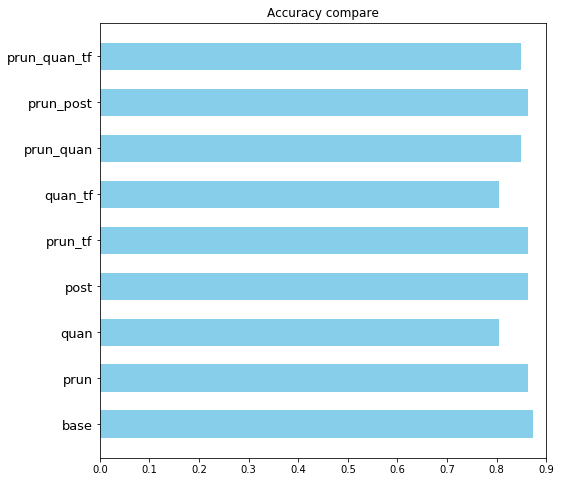

In [56]:
from matplotlib import pyplot as plt

y = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

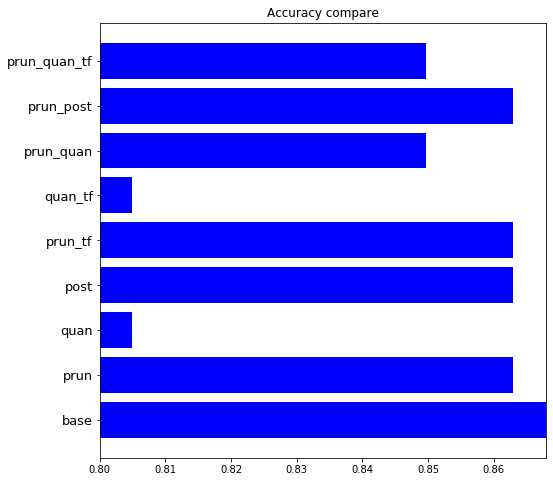

In [58]:
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="blue")
plt.xlim(0.80,0.868)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

### 모든 모델의 크기

In [59]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [60]:
print("Size of gzipped baseline Keras model: %.2f bytes\n" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped quantizied Keras model: %.2f bytes\n" % (get_gzipped_model_size(quantized_keras_file)))
print("Size of gzipped post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quan_tflite_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_tflite_file)))
print("Size of gzipped quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(quantized_tflite_file)))
print("Size of gzipped pruned and quantized Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_and_quantized_keras_file)))
print("Size of gzipped pruned and post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quantized_and_pruned_tflite_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_quantized_tflite_file)))


Size of gzipped baseline Keras model: 380323.00 bytes

Size of gzipped pruned Keras model: 79566.00 bytes

Size of gzipped quantizied Keras model: 363799.00 bytes

Size of gzipped post-quantized model: 144.00 bytes

Size of gzipped pruned TFlite model: 67045.00 bytes

Size of gzipped quantized TFlite model: 37234.00 bytes

Size of gzipped pruned and quantized Keras model: 362188.00 bytes

Size of gzipped pruned and post-quantized model: 18861.00 bytes

Size of gzipped pruned and quantized TFlite model: 43970.00 bytes



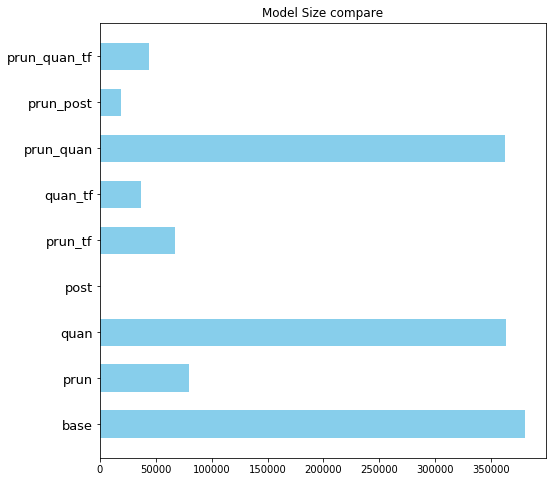

In [61]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]


x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

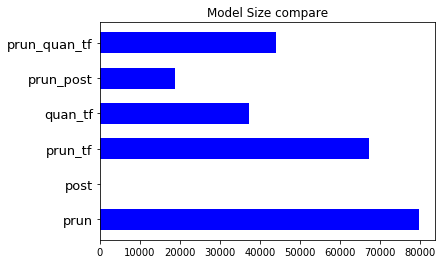

In [62]:
y = [get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

x = ["prun", "post",
     "prun_tf","quan_tf",
     "prun_post", "prun_quan_tf"]

plt.barh(x, y, color="blue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

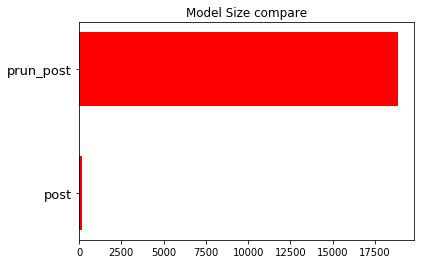

In [63]:
y = [get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file)]

x = ["post",
     "prun_post"]

plt.barh(x, y, color="red", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

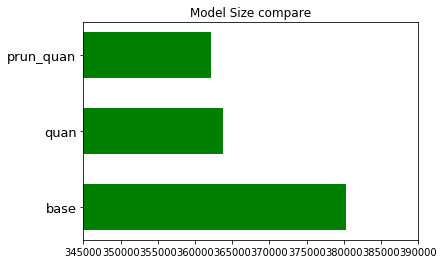

In [64]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file)]


x = ["base", "quan", "prun_quan"]

plt.barh(x, y, color="green", height=0.6)
plt.xlim(345000, 390000)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

### accuracy and model size

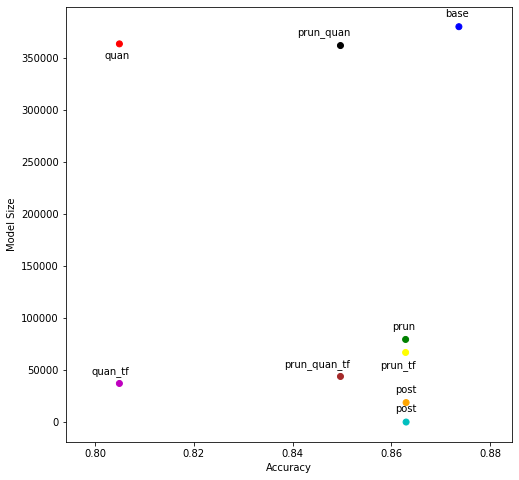

In [71]:
x = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m','k','orange',"brown"]
d = [(10,10),(10,10),(10,-15),(10,10),(10,-15),(10,10),(10,10),(10,10),(10,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()

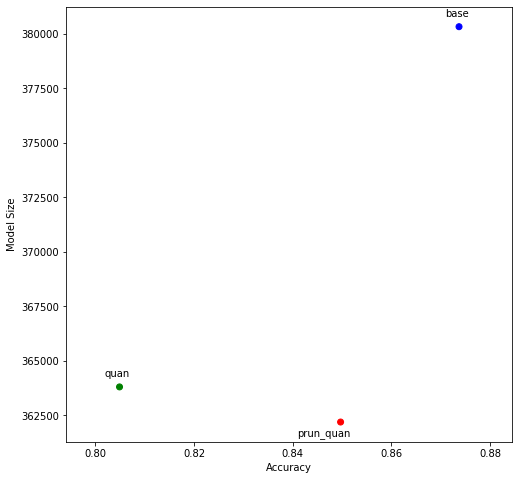

In [76]:
x = [baseline_model_accuracy,
     q_aware_model_accuracy,
     q_aware_prun_model_accuracy]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file)]

z = ["base", "quan", "prun_quan"]

c = ['b','g','r']
d = [(10,10),(10,10),(10,-15)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()

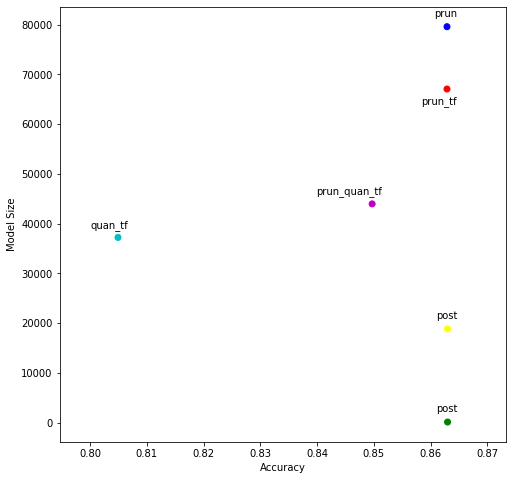

In [67]:
x = [model_for_pruning_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["prun", "post",
     "prun_tf","quan_tf",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m']
d = [(10,10),(10,10),(10,-15),(10,10),(10,-15),(10,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()